<a href="https://colab.research.google.com/github/spiyer99/HFEA_VAR/blob/main/Hedgefundie_Value_at_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attempt 2: Get daily returns from backtrader

In [25]:
!pip install backtrader yfinance arch

In [26]:
import backtrader as bt
from pandas_datareader import data as pdr
from pathlib import Path
import os
from arch import arch_model
import numpy as np
from random import gauss, seed
from scipy.stats import binom
import pandas as pd
import datetime
import yfinance as yf

yf.pdr_override()

In [27]:
def sim_leverage(proxy, leverage=1, expense_ratio = 0.0, initial_value=1.0):
    pct_change = proxy.pct_change(1)
    pct_change = (pct_change - expense_ratio / 252) * leverage
    sim = (1 + pct_change).cumprod() * initial_value
    sim[0] = initial_value
    return sim

In [28]:
start = datetime.datetime(1986, 5, 19)
end = datetime.datetime(2021, 6, 12)

vfinx = pdr.get_data_yahoo("VFINX", start, end)["Adj Close"]
qqq = pdr.get_data_yahoo("QQQ", datetime.datetime(2000, 3, 1), end)["Adj Close"]
vustx = pdr.get_data_yahoo("VUSTX", start, end)["Adj Close"]
psq = pdr.get_data_yahoo("PSQ", start, end)["Adj Close"]

upro_sim = sim_leverage(vfinx, leverage=3.0, expense_ratio=0.0092).to_frame("close")
tqqq_sim = sim_leverage(qqq, leverage=3.0, expense_ratio=0.0092).to_frame("close")
tmf_sim = sim_leverage(vustx, leverage=3.0, expense_ratio=0.0109).to_frame("close")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [29]:
for column in ["open", "high", "low"]:
    upro_sim[column] = upro_sim["close"]
    tmf_sim[column] = tmf_sim["close"]
    tqqq_sim[column] = tqqq_sim["close"]
    
upro_sim["volume"] = 0
tqqq_sim["volume"] = 0
tmf_sim["volume"] = 0

upro_sim = bt.feeds.PandasData(dataname=upro_sim)
tmf_sim = bt.feeds.PandasData(dataname=tmf_sim)
tqqq_sim = bt.feeds.PandasData(dataname=tqqq_sim) 

In [30]:
def backtest(datas, strategy, plot=False, **kwargs):
    cerebro = bt.Cerebro()
    for data in datas:
        cerebro.adddata(data)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.Returns)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    if Path('hedgefundie_strategy_daily_returns.csv').exists(): os.remove('hedgefundie_strategy_daily_returns.csv')
    cerebro.addwriter(bt.WriterFile, csv = True, out='hedgefundie_strategy_daily_returns.csv')
    cerebro.addstrategy(strategy, **kwargs)
    results = cerebro.run()
    if plot:
        cerebro.plot()
    return (results[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
            results[0].analyzers.returns.get_analysis()['rnorm100'],
            results[0].analyzers.sharperatio.get_analysis()['sharperatio'])

In [31]:
class AssetAllocation(bt.Strategy):
    params = (
        ('equity',0.6),
    )
    def __init__(self):
        self.UPRO = self.datas[0]
        self.TMF = self.datas[1]
        self.counter = 0
        
    def next(self):
        if  self.counter % 252 == 0: # annual rebalance
            self.order_target_percent(self.UPRO, target=self.params.equity)
            self.order_target_percent(self.TMF, target=(1 - self.params.equity))
        self.counter += 1

In [32]:
dd, cagr, sharpe = backtest([upro_sim, tmf_sim], AssetAllocation, plot=True, equity=0.55)
print(f"Max Drawdown: {dd:.2f}%\nCAGR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")

Max Drawdown: 54.66%
CAGR: 16.27%
Sharpe: 0.592


In [33]:
def fix_csv(name = 'hedgefundie_strategy_daily_returns.csv'):
  # fix the fix exported by cerebro
  with open(name,'r') as f:
    new_name = Path(name).stem + '_fixed.csv'
    if Path(new_name).exists(): os.remove(new_name)
    with open(Path(name).stem + '_fixed.csv','w') as f1:
        next(f) # skip header line
        for line in f:
            f1.write(line)
fix_csv()

In [34]:
backtest = pd.read_csv('hedgefundie_strategy_daily_returns_fixed.csv', parse_dates = True)
cols = ['datetime', 'open', 'high', 'low', 'close', 'volume', 'value']
backtest = backtest[backtest['datetime'].notnull()][cols].reset_index(drop=True)
backtest.head()

,datetime,open,high,low,close,volume,value
0,1986-05-19 00:00:00,1.000000,1.000000,1.000000,1.000000,0.0,10000.000000
1,1986-05-20 00:00:00,1.037538,1.037538,1.037538,1.037538,0.0,10000.000000
2,1986-05-21 00:00:00,1.030191,1.030191,1.030191,1.030191,0.0,9959.593644
3,1986-05-22 00:00:00,1.091267,1.091267,1.091267,1.091267,0.0,10295.507652
4,1986-05-23 00:00:00,1.107348,1.107348,1.107348,1.107348,0.0,10383.958368


In [35]:
backtest.plot(figsize=(10,10))

<IPython.core.display.Javascript object>

In [36]:
backtest['return'] = backtest['value'].pct_change()

In [37]:
return_list=backtest['return'].tolist()[1:]

GARCH(1,1) model is used to determined the volatility.

In [38]:
# Using GARCH(1,1) to determine the volatility
model = arch_model(return_list, mean='Zero', vol='GARCH', p=1, q=1)
model_fit = model.fit()
volatility = model_fit.conditional_volatility
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003138. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration:      1,   Func. Count:      5,   Neg. LLF: -23438.325824725303
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -23438.325854447183
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                23438.3
Distribution:                  Normal   AIC:                          -46870.7
Method:            Maximum Likelihood   BIC:                          -46849.4
                                        No. Observations:                 8693
Date:                Fri, Jul 30 2021   Df Residuals:                     8693
Time:                        01:05:55   Df Model:                            0
      

Estimate the Volatility in the next date with the GARCH(1,1) model

In [39]:
# Estimate the volatility in the next date
omega = model_fit.params['omega'] 
alpha = model_fit.params['alpha[1]']
beta = model_fit.params['beta[1]']
vola_estimate = omega + alpha * np.power(return_list[-1] , 2)  + beta * np.power( volatility[-1] , 2 )
vola_estimate = np.sqrt(vola_estimate)
print('The volatility in the next date=', vola_estimate )
#return_scienarios = []
#for i in range(0,return_list)

The volatility in the next date= 0.016502061111247215


Value at Risk Calculation: historical simulation with volatility updating

In [40]:
# calculate the predicted value in the next date under different scenario and inporporate volatility updating
Market_scienarios = []
N_history = len(return_list)
Value_current = backtest.loc[backtest.index[-1], 'value']
backtest.loc[backtest.index[-1], 'value']
for i in range(0, N_history ):
  Market_value = Value_current *  ( 1 + return_list[i] * vola_estimate/volatility[i] )
  Market_scienarios.append(Market_value)

In [41]:
# Value at Risk (VaR) determination
# CL_Var: condifence level for VaR
CL_VaR = 95
Value_current = backtest.loc[backtest.index[-1], 'value']
Value_at_Risk = np.percentile(Market_scienarios,100-CL_VaR) -  Value_current
print("The 1 day", CL_VaR,"% VaR:", -Value_at_Risk)

The 1 day 95 % VaR: 47264.910781804705


In [42]:
# Make the histogram of loss for the scenaros considered between current date and the next date
import matplotlib.pyplot as plt
mss = np.asarray(Value_current - Market_scienarios )

plt.xlim([min(mss), max(mss)])

plt.hist(mss, bins='auto', alpha=0.5)
plt.title('Plot of loss for the scenaros')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.axvline( -Value_at_Risk , color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(-Value_at_Risk*1.1, max_ylim*0.9, '{}% VaR: {:.2f}'.format(CL_VaR ,-Value_at_Risk))
plt.show()

Value-at-Risk backtesting:
here the binomial one-tailed test is used

In [43]:
# Confidence level for backtesting
CL_backtesting = 95
# The probability of the VaR beeing exceeded on given day
p = 1 - CL_VaR/100
N_confidence = binom.ppf( CL_backtesting*0.01, N_history, p)
N_exceeded = sum( v < Value_at_Risk + Value_current for v in Market_scienarios)

print("We look at total", N_history,"days. VaR level is reached at", N_exceeded , "days.")
if N_exceeded <= N_confidence:
  print ("This VaR model is accepted at", CL_backtesting,"% confidence level.")
else:
  print ("This VaR model is rejected at", CL_backtesting,"% confidence level.")

We look at total 8693 days. VaR level is reached at 435 days.
This VaR model is accepted at 95 % confidence level.


# Attempt 1: Single long VAR

In [61]:
!pip install arch

In [62]:
# example of ARCH model
import numpy as np
from random import gauss
from random import seed
from matplotlib import pyplot
from arch import arch_model
import datetime
import pandas as pd
# from pandas_datareader import data as pdr
# import yfinance as yf
from scipy.stats import binom

Read and preprocess the data such as calculating the continously compounded return.

In [118]:
# hedgefundie monthly returns taken from: 
# https://www.portfoliovisualizer.com/backtest-portfolio?s=y&timePeriod=2&startYear=1985&firstMonth=8&endYear=2021&lastMonth=12&calendarAligned=true&includeYTD=false&initialAmount=10000&annualOperation=0&annualAdjustment=0&inflationAdjusted=true&annualPercentage=0.0&frequency=4&rebalanceType=3&absoluteDeviation=5.0&relativeDeviation=25.0&reinvestDividends=true&showYield=false&showFactors=false&factorModel=3&benchmark=VFINX&portfolioNames=true&portfolioName1=3x+AWG&portfolioName2=Hedgefundie+55%2F45&portfolioName3=Portfolio+3&symbol1=VFINX&allocation1_1=90&allocation1_2=165&symbol2=VUSTX&allocation2_1=120&allocation2_2=135&symbol3=VFITX&allocation3_1=45&symbol4=%5EGOLD&allocation4_1=30&symbol5=GSG&symbol6=CASHX&allocation6_1=-185&allocation6_2=-200&symbol7=IJH&symbol8=IJR
data = pd.read_csv("hedgefundie_monthly_returns.csv", dtype = {'Year': int, 'Month': int, 'Return': 'string', 'Balance': 'string'}) 
data['Return'] = data['Return'].str.replace('%', '').astype(float)
data['Return'] = (data['Return']/100).astype(float)
data['Balance'] = data['Balance'].str.replace('$', '')
data['Balance'] = data['Balance'].str.replace(',', '').astype(float)
data.head()

,Year,Month,Return,Balance
0,1991,11,-0.0740,9260.0
1,1991,12,0.2778,11833.0
2,1992,1,-0.0809,10875.0
3,1992,2,0.0239,11136.0
4,1992,3,-0.0557,10515.0


In [119]:
return_list=data['Return'].tolist()

GARCH(1,1) model is used to determined the volatility.

In [120]:
# Using GARCH(1,1) to determine the volatility
model = arch_model(return_list, mean='Zero', vol='GARCH', p=1, q=1)
model_fit = model.fit()
volatility = model_fit.conditional_volatility
print(model_fit.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: -428.1139665133687
Iteration:      2,   Func. Count:     13,   Neg. LLF: -428.1925706963546
Iteration:      3,   Func. Count:     20,   Neg. LLF: -428.336400163769
Iteration:      4,   Func. Count:     26,   Neg. LLF: -428.4391125510042
Iteration:      5,   Func. Count:     32,   Neg. LLF: -428.4751234916761
Iteration:      6,   Func. Count:     37,   Neg. LLF: -428.4817581531861
Iteration:      7,   Func. Count:     42,   Neg. LLF: -428.48270478855306
Iteration:      8,   Func. Count:     47,   Neg. LLF: -428.48271083311005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -428.4827108330161
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 8
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-s

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005512. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Estimate the Volatility in the next date with the GARCH(1,1) model

In [121]:
# Estimate the volatility in the next date
omega = model_fit.params['omega'] 
alpha = model_fit.params['alpha[1]']
beta = model_fit.params['beta[1]']
vola_estimate = omega + alpha * np.power(return_list[-1] , 2)  + beta * np.power( volatility[-1] , 2 )
vola_estimate = np.sqrt(vola_estimate)
print('The volatility in the next date=', vola_estimate )
#return_scienarios = []
#for i in range(0,return_list)

The volatility in the next date= 0.07786391557051343


Value at Risk Calculation: historical simulation with volatility updating

In [122]:
# calculate the predicted value in the next date under different scenario and inporporate volatility updating
Market_scienarios = []
N_history = len(return_list)
Value_current = df.loc[df.index[-1], 'value']
df.loc[df.index[-1], 'value']
for i in range(0, N_history ):
  Market_value = Value_current *  ( 1 + return_list[i] * vola_estimate/volatility[i] )
  Market_scienarios.append(Market_value)

In [123]:
# Value at Risk (VaR) determination
# CL_Var: condifence level for VaR
CL_VaR = 95
Value_current = df.loc[df.index[-1], 'value']
Value_at_Risk = np.percentile(Market_scienarios,100-CL_VaR) -  Value_current
print("The 1 Month", CL_VaR,"% VaR:", -Value_at_Risk)

The 1 Month 95 % VaR: 1.3969630967506657


<IPython.core.display.Javascript object>

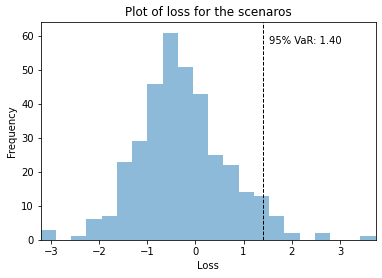

In [124]:
# Make the histogram of loss for the scenaros considered between current date and the next date
import matplotlib.pyplot as plt
mss = np.asarray(Value_current - Market_scienarios )

plt.xlim([min(mss), max(mss)])

plt.hist(mss, bins='auto', alpha=0.5)
plt.title('Plot of loss for the scenaros')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.axvline( -Value_at_Risk , color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(-Value_at_Risk*1.1, max_ylim*0.9, '{}% VaR: {:.2f}'.format(CL_VaR ,-Value_at_Risk))
plt.show()

Value-at-Risk backtesting:
here the binomial one-tailed test is used

In [127]:
# Confidence level for backtesting
CL_backtesting = 95
# The probability of the VaR beeing exceeded on given day
p = 1 - CL_VaR/100
N_confidence = binom.ppf( CL_backtesting*0.01, N_history, p)
N_exceeded = sum( v < Value_at_Risk + Value_current for v in Market_scienarios)

print("We look at total", N_history,"months. VaR level is reached at", N_exceeded , "months.")
if N_exceeded <= N_confidence:
  print ("This VaR model is accepted at", CL_backtesting,"% confidence level.")
else:
  print ("This VaR model is rejected at", CL_backtesting,"% confidence level.")

We look at total 356 months. VaR level is reached at 18 months.
This VaR model is accepted at 95 % confidence level.
